# Spatial Smoothing with GAMs in Python (with some plotting too)

In this notebook I'll examine a spatial smoothing example from S. Wood's book *Generalized Additive Models* (2006/2017) using Python and the PyGam library. Wood examines a data-set related to a mackerel egg survey off the cost of northwestern Europe. https://rdrr.io/cran/gamair/man/mack.html

## How the data was aquired

In order to obtain the `mack.csv` data, I explored the data from R (the data is found in the `gamair`: *Data for 'GAMs: An Introduction with R* package) and removed the first `id` column, saved it as a `.csv` file and placed it in the same directory as this notebook.  

## Libraries for Analysis

The code chunk below lists the libraries required for this analysis:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import seaborn as sns
import folium
import scipy
from pygam import PoissonGAM, LinearGAM, s, f, te

In [2]:
## Uncomment  to insall the pygam library using pip
# ! pip install pygam

## EDA and Plotting

Before modeling let's examine the the data set for quality and generate some plots:

In [3]:
## read it in
mack = pd.read_csv('mack.csv')

## basic summary stats.
mack.describe()

egg.count    egg.dens      b.depth         lat         lon  \
count  634.000000  634.000000   634.000000  634.000000  634.000000   
mean    13.362776   38.223975   836.373817   48.002492   -6.290158   
std     22.171262   70.464756  1113.746204    3.162722    3.845339   
min      0.000000    0.000000     8.000000   44.020000  -14.780000   
25%      0.000000    0.000000   121.000000   45.620000   -9.770000   
50%      1.000000    5.125000   171.500000   46.620000   -4.670000   
75%     20.000000   41.475000  1298.500000   49.750000   -2.900000   
max    140.000000  601.780000  4450.000000   57.750000   -1.280000   

             time    salinity           flow     s.depth   temp.surf  \
count  634.000000  330.000000     634.000000  634.000000  634.000000   
mean    12.027539   35.423788    8738.077287  121.359621   15.299495   
std      6.734979    0.306062   25633.343086   49.038238    2.077583   
min      0.000000   34.270000      90.000000    4.000000   11.400000   
25%      6.155000   35.340000     373.000000   98.000000   13.100000   
50%     12.010000   35.500000     413.000000  101.000000   15.700000   
75%     17.677500   35.630000    4988.750000  170.500000   17.100000   
max     23.970000   35.900000  305938.000000  231.000000   19.700000   

         temp.20m    net.area  vessel.haul      c.dist  
count  634.000000  634.000000   634.000000  634.000000  
mean    15.008912    0.214114   396.630915    0.558331  
std      2.316972    0.036138   605.496675    0.450823  
min     10.200000    0.150000     1.000000    0.000253  
25%     12.700000    0.190000    88.000000    0.215747  
50%     15.500000    0.242000   337.500000    0.440166  
75%     17.100000    0.242000   480.750000    0.794072  
max     19.700000    0.242000  3911.000000    2.567603

The data contains 634 observations with 16 variables. We expect to use `egg.count` as the response variable and use `lat` and `lon`, at the very least, to produce a spatially smoothed plot of the expected number of eggs across the region of interest. The average count of eggs is about 13.4 with a standard deviation of 22.2. The quality of the data seems reasonable, e.g. no negative values where there ought to be a positive value such as -99 representing a missing value. The `flow` variable is measured on the largest scale.

Let's examine if any missing values are present:

In [4]:
mack.isnull().sum()

egg.count        0
egg.dens         0
b.depth          0
lat              0
lon              0
time             0
salinity       304
flow             0
s.depth          0
temp.surf        0
temp.20m         0
net.area         0
country          0
vessel           0
vessel.haul      0
c.dist           0
dtype: int64

Only the `salinity` variable contains 304 missing values, about 48%. 

### Map of Survey locations

The `folium` library provides a quick way of generating interactive maps. Here, I'll reproduce the left panel of figure 5.16 (a bubble plot of the data) using `folium`. The user can zoom in/out on a specific location as they desire.

A few notes:

* I off-set the starting latitude to make the data fit better in the plotting window
* The `egg.count` is scaled (reduced) by a factor of 10 to make the circle sizes more reasonable.

In [5]:
map_mack = folium.Map(location = [mack['lat'].mean()+4, mack['lon'].mean()], zoom_start = 5)

for lat, lon, egg in zip(mack['lat'], mack['lon'], mack['egg.count']):
    label = '{} Mackerel Eggs'.format(egg)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=egg/10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mack)  
    
map_mack

The plot suggests some degree of spatial dependence on the number of mackerel eggs across region of interest. Northern locations tend to have higher counts compared to lower locations, such as in the Bay of Biscay in particular. Locations further west also tend to have higher counts. Maybe there is a balance between distance from the shore and location that effects the count of eggs?

### Scatter Plots

Given the observations from the map above, let's produce scatter plots of latitude and longitude separately:

[Text(0.5, 0, 'Longitude (degrees W)'),
 Text(0, 0.5, 'Egg Count'),
 Text(0.5, 1.0, 'Count vs. Longitude')]

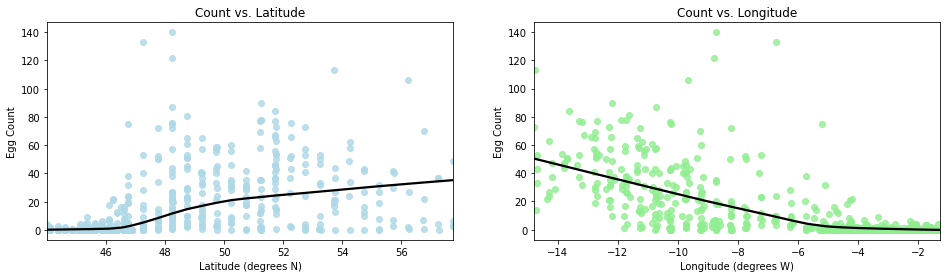

In [6]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 4, forward = True)

## egg.count vs latitude
lat_plt = sns.regplot(x = 'lat', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "lightblue"}, line_kws={"color": "black"},
                      ax = ax[0])
lat_plt.set(xlabel="Latitude (degrees N)", ylabel = "Egg Count", title = "Count vs. Latitude")

## egg.count vs longitude
lon_plt = sns.regplot(x = 'lon', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "lightgreen"}, line_kws={"color": "black"},
                      ax = ax[1])
lon_plt.set(xlabel="Longitude (degrees W)", ylabel = "Egg Count", title = "Count vs. Longitude")

The data and LOESS curve suggest some degree of non-linear behavior in the data. Let's see if there is an effect due to temperature. The data provides temperature measurements at both the surface and 20 meters below:

[Text(0.5, 0, '20 meter Temperature'),
 Text(0, 0.5, 'Egg Count'),
 Text(0.5, 1.0, 'Count vs. Temp. @ 20m')]

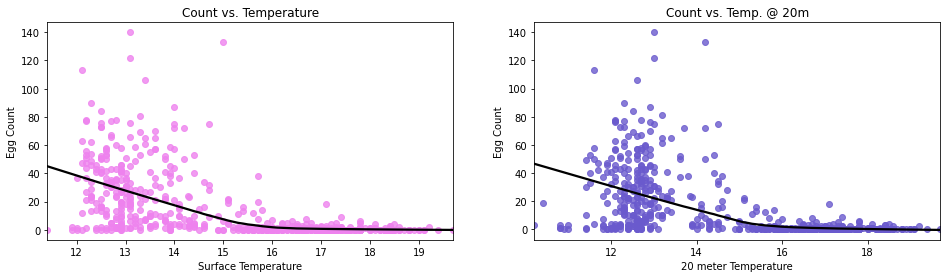

In [7]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 4, forward = True)

## egg.count vs surface temp
temp_plt = sns.regplot(x = 'temp.surf', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "violet"}, line_kws={"color": "black"},
                      ax = ax[0])
temp_plt.set(xlabel="Surface Temperature", ylabel = "Egg Count", title = "Count vs. Temperature")

## egg.count vs temp at 20 m
temp20_plt = sns.regplot(x = 'temp.20m', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "slateblue"}, line_kws={"color": "black"},
                      ax = ax[1])
temp20_plt.set(xlabel="20 meter Temperature", ylabel = "Egg Count", title = "Count vs. Temp. @ 20m")

Finding more eggs at a location is associated with surface temperatures and temperatures at 20 meters below the surface below 16-degrees Celsius. Notably, both explanatory variables have very similar associations with the response.There is some degree of non-linear behavior (i.e. the LOESS smoother has concavity as observed with the spatial variables). 

Now, let's examine the two depth variables, `b.depth` and `s.depth`:

[Text(0.5, 0, 'Initial Depth of Sampling Net'),
 Text(0, 0.5, 'Egg Count'),
 Text(0.5, 1.0, 'Count vs. Alternate Depth')]

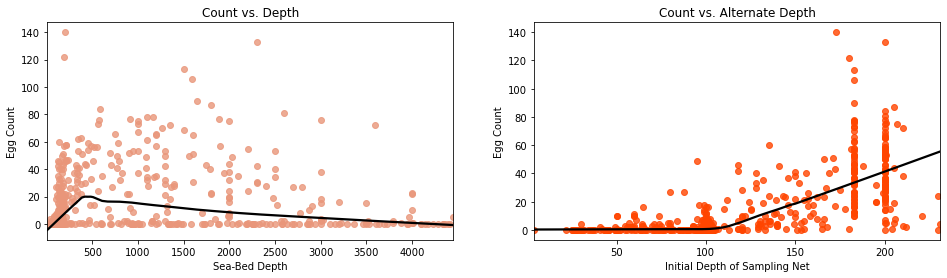

In [8]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 4, forward = True)

## egg.count vs b.deph
bdepth_plt = sns.regplot(x = 'b.depth', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "darksalmon"}, line_kws={"color": "black"},
                      ax = ax[0])
bdepth_plt.set(xlabel="Sea-Bed Depth", ylabel = "Egg Count", title = "Count vs. Depth")

## egg.count vs s.depth
sdepth_plt = sns.regplot(x = 's.depth', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "orangered"}, line_kws={"color": "black"},
                      ax = ax[1])
sdepth_plt.set(xlabel="Initial Depth of Sampling Net", ylabel = "Egg Count", title = "Count vs. Alternate Depth")

We see some non-linear relationships with the different depth variables. Now, let's examine the salinity (which has nearly half of the observations missing) and the flow rate i.e. the variables that characterize the water at the survey locations.

[Text(0.5, 0, 'Water Salinity'),
 Text(0, 0.5, 'Egg Count'),
 Text(0.5, 1.0, 'Count vs. Salinity')]

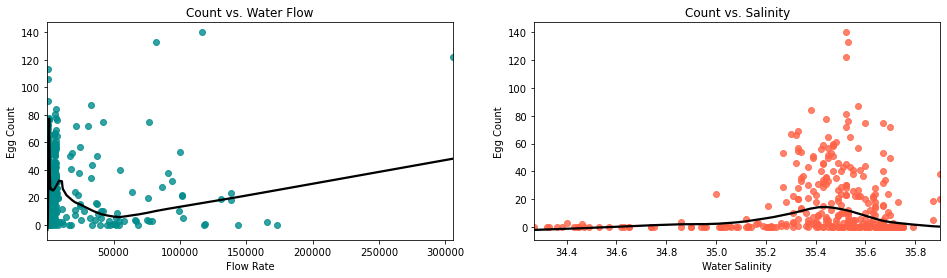

In [9]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 4, forward = True)

## egg.count vs b.deph
flow_plt = sns.regplot(x = 'flow', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "darkcyan"}, line_kws={"color": "black"},
                      ax = ax[0])
flow_plt.set(xlabel="Flow Rate", ylabel = "Egg Count", title = "Count vs. Water Flow")

## egg.count vs s.depth
salt_plt = sns.regplot(x = 'salinity', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "tomato"}, line_kws={"color": "black"},
                      ax = ax[1])
salt_plt.set(xlabel="Water Salinity", ylabel = "Egg Count", title = "Count vs. Salinity")

The LOESS smoother may be slightly misleading for the flow plot: the locations with high flow are likely pulling the smoother, but is not associated with higher or lower egg counts. Similarly with salinity, there may be some association with higher egg counts been 35.2 and 35.8, but this may be due to more observations being measured at these locations. There are two remaining plots that can be examine: the time of day and `c.dist` which represents: *The distance from the sample location to the 200m contour measured in degrees as if degrees latitude equal degrees longitude, which actually they don't* as stated in the data documentation. 

[Text(0.5, 0, 'Contour Distance'),
 Text(0, 0.5, 'Egg Count'),
 Text(0.5, 1.0, ' Egg Count vs. c.dist')]

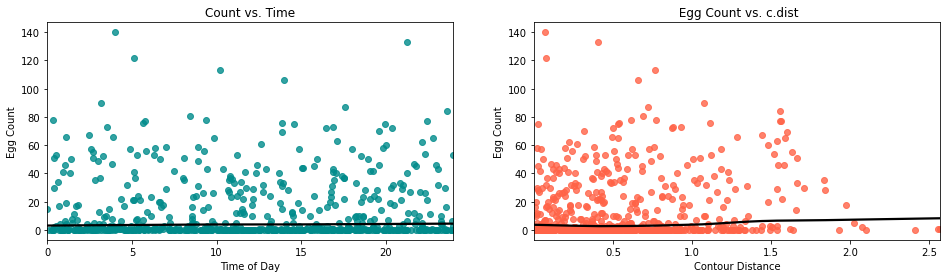

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 4, forward = True)

## egg.count vs b.deph
time_plt = sns.regplot(x = 'time', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "darkcyan"}, line_kws={"color": "black"},
                      ax = ax[0])
time_plt.set(xlabel="Time of Day", ylabel = "Egg Count", title = "Count vs. Time")

## egg.count vs s.depth
cdist_plt = sns.regplot(x = 'c.dist', y = 'egg.count', 
                      data = mack, 
                      lowess = True,
                      scatter_kws={"color": "tomato"}, line_kws={"color": "black"},
                      ax = ax[1])
cdist_plt.set(xlabel="Contour Distance", ylabel = "Egg Count", title = " Egg Count vs. c.dist")

There seems to be very little association with the surveyed egg counts and these variables.

### EDA Summary

The EDA process generates some relevant information that might be useful during the modeling phase:

* The response variable is a count, therefore a model ought to take this into account. A GAM can fit a count response (or any response from an exponential family).

* The bubble-chart map suggests spatial dependence on the egg count. A GAM can smooth/interpolate the data based on the latitude an longitude. A model of this this form would allow us to make predictions at any location in the area of interest and quantify the uncertainty. 

* Given a spatial model, does inclusion of the other variables yield a better model? 
    - The univariate scatter plots suggest temperatures and depths have an obvious relationship with the response, and to a lesser extent salinity and water flow rate. The time and `c.dist` variables appear to not be strongly associated with egg counts.
    - Starting with a model that uses the spatial variables we can examine if including the other variables changes the AIC (we favor smaller/lower AICs). If the AIC changes enough, we could perform an $F$-test comparing the two models to see if the additional explanatory variable is significant.
    - We may be interested in how water temperature effects egg production, especially as the effects of climate change are becoming more prevalent. 

## Modeling with GAMS

Using the `pygam` library, we can begin fitting GAMs. W include an off-set term as the net area for the Poisson modeling, using the `exposure` argument in the `fit` method.  Let's first consider a model only with the spatial variables:

### Spatial Model

We examine a model of the form $log(y) = s_1(\mbox{lat})+s_2(\mbox{lon})+te(\mbox{lat},\mbox{lon}) + \epsilon$

In [11]:
X_spatial = mack[['lat', 'lon']].values
y = mack[['egg.count']].values
net_offset = -np.log(mack['net.area'])

## model
spatial_gam = PoissonGAM(s(0) + s(1) + te(0,1) )
spatial_gam.fit(X_spatial, y, exposure = net_offset )

spatial_gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                      39.829
Link Function:                          LogLink Log Likelihood:                                  -2825.714
Number of Samples:                          634 AIC:                                             5731.0861
                                                AICc:                                            5736.8541
                                                UBRE:                                               8.6516
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7597
Feature Function                  Lam

C:\Users\jddru\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  if __name__ == '__main__':


The model summary suggests an 76% improvement over a null model when using spatial variables only. Note that by removing the interaction term we reduce the pseudo-R-squared to about 67% and increase the AIC to 7299.7, suggesting the spatial interaction term is a useful component in the model. One of the advantages of GAMs is their interpretability. Let's examine the marginal effects for each of the smooths: first the latitude and longitude smooths:

<Figure size 432x288 with 0 Axes>

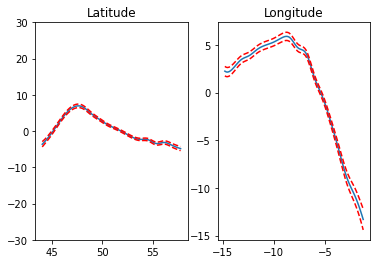

In [12]:
## plotting
plt.figure();
fig, axs = plt.subplots(1,2);

titles = ['Latitude', 'Longitude']
for i, ax in enumerate(axs):
    XX = spatial_gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], spatial_gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], spatial_gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

Non-linear behavior is present in the model as described by the smooths above. We can also visualize the interaction term as well:

C:\Users\jddru\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


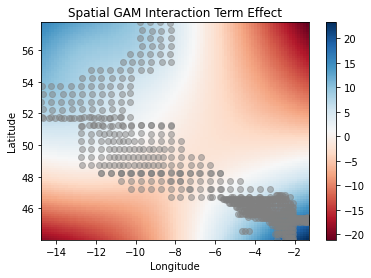

In [13]:
fig, ax = plt.subplots()

XX = spatial_gam.generate_X_grid(term=2, meshgrid=True)
c = ax.pcolormesh(XX[1], XX[0], 
                  spatial_gam.partial_dependence(term=2, X=XX, meshgrid=True), 
                  cmap='RdBu')
plt.scatter(mack[['lon']], mack[['lat']], color = 'grey', alpha = 0.5)
ax.set_title('Spatial GAM Interaction Term Effect')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# set the limits of the plot to the limits of the data
ax.axis([XX[1].min(), XX[1].max(), XX[0].min(), XX[0].max()])
fig.colorbar(c, ax=ax)

plt.show()

Note that we need to be careful with extrapolation when looking at this plot and only focus our attention to the area with observations (grey circles). The difference in AIC suggests the the interaction term is important and ought be be retained in the model. From a qualitative perspective we see that the interaction between latitude and longitude decreases in the area around 48N and 8W. Let's examine a few residual plots based on the deviance residuals:

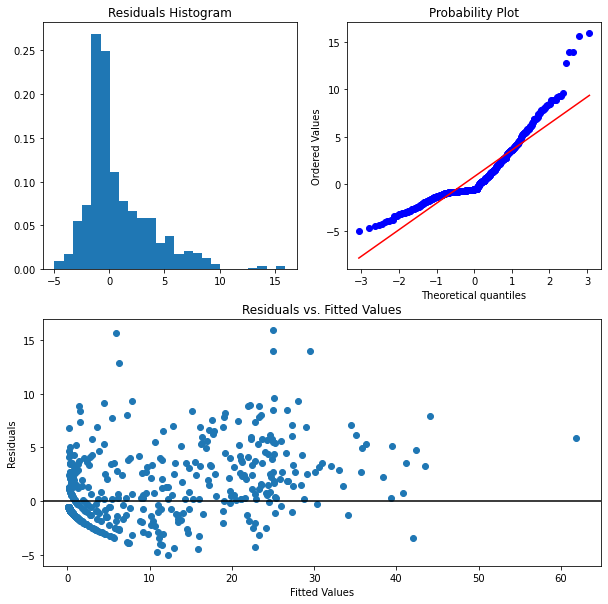

In [14]:
def diagnosticPlots(model, X_grid, y_values):
    
    ## compute values
    residuals = model.deviance_residuals(X_grid, y_values)
    fitted = model.predict(X_grid)
    
    ## generate plots
    
    fig, axs = plt.subplots(2,2);

    fig.set_size_inches(10, 10, forward = True)
    plt.subplot(221)
    plt.hist(residuals, bins = 25, density = True)
    plt.title('Residuals Histogram')
    plt.subplot(222)
    scipy.stats.probplot(residuals, plot=plt)
    plt.subplot(212)
    plt.scatter(fitted, residuals)
    plt.axhline(y=0, color='k', linestyle='-')
    plt.title('Residuals vs. Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    plt.show()

diagnosticPlots(spatial_gam, X_spatial, y)

The residuals indicate some degree of right-skewnees and a slight violation of assumptions, but not pattern appears in the plot of the residuals versus the fitted values. As Wood notes and calculates in the text there is over-dispersion in the data. 

### The Effect of Temperature

In the EDA phase, we noticed that both temperature variables were associated with the egg count. Temperature may be a variable of interest as the effects of climate change may potential warm the mackerel spawning ares. We consider two different models that build on the spatial model: the first include surface temperature and the second includes temperature at a 20 meter depth. The one which provides the lower AIC score will be selected:

* Temperature Model I: $log(y) = s_1(\mbox{lat})+s_2(\mbox{lon})+ s_3(\mbox{surface temp}) + te(\mbox{lat},\mbox{lon}) + \epsilon$
* Temperature Model II: $log(y) = s_1(\mbox{lat})+s_2(\mbox{lon})+ s_3(\mbox{depth temp}) + te(\mbox{lat},\mbox{lon}) + \epsilon$

In [15]:
X_tempSurf = mack[['lat', 'lon', 'temp.surf']].values
X_temp20 = mack[['lat', 'lon', 'temp.20m']].values

## models
tempSurf_gam = PoissonGAM(s(0) + s(1) + s(2) + te(0,1) )
tempSurf_gam.fit(X_tempSurf, y, exposure = net_offset )

temp20_gam = PoissonGAM(s(0) + s(1) + s(2) + te(0,1) )
temp20_gam.fit(X_temp20, y, exposure = net_offset )

PoissonGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, terms=s(0) + s(1) + s(2) + te(0, 1) + intercept, 
   tol=0.0001, verbose=False)

The summary for the surface temperature model:

In [16]:
tempSurf_gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     52.0615
Link Function:                          LogLink Log Likelihood:                                 -2737.9506
Number of Samples:                          634 AIC:                                             5580.0242
                                                AICc:                                            5589.9169
                                                UBRE:                                               8.4288
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                     0.77
Feature Function                  Lam

C:\Users\jddru\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


The summary for the model with temperature measured 20 meters below the surface:

In [17]:
temp20_gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     52.4068
Link Function:                          LogLink Log Likelihood:                                 -2691.2621
Number of Samples:                          634 AIC:                                             5487.3379
                                                AICc:                                            5497.3646
                                                UBRE:                                                8.283
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7755
Feature Function                  Lam

C:\Users\jddru\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


The model with temperature measured below the surface produces a smaller AIC than the model with surface temperature and the spatial model. The smooths for the main effects look like:

<Figure size 432x288 with 0 Axes>

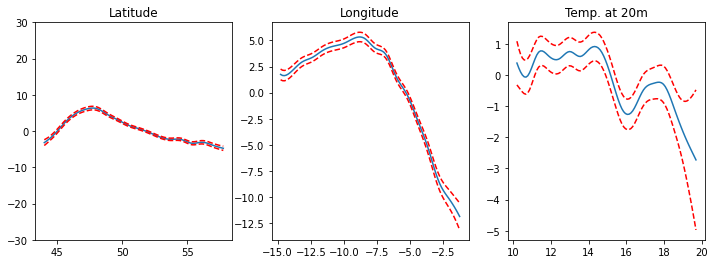

In [18]:
## plotting
plt.figure();
fig, axs = plt.subplots(1,3);
fig.set_size_inches(12, 4, forward = True)

titles = ['Latitude', 'Longitude', 'Temp. at 20m']
for i, ax in enumerate(axs):
    XX = temp20_gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], temp20_gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], temp20_gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);

The marginal effects change slightly when including the temperature variable. Let's examine the residual diagnostics:

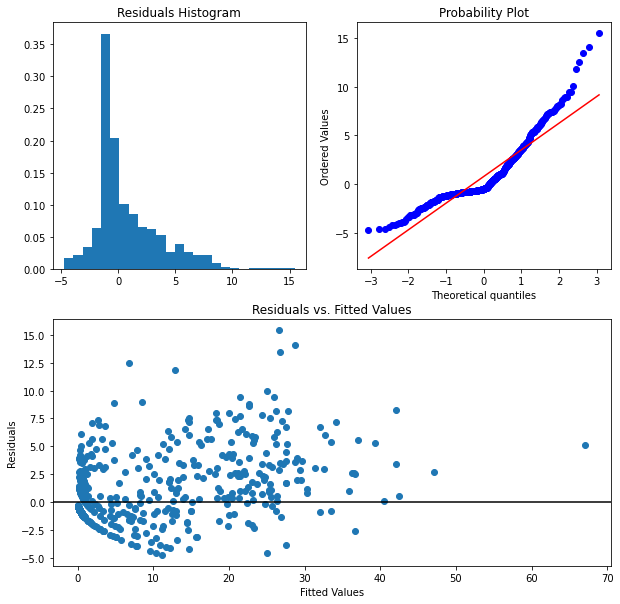

In [19]:
diagnosticPlots(temp20_gam, X_temp20, y)

We obtain similar residual diagnostics as before. Using the model objects, we can compute a deviance based F-statistic to see if the inclusion of the temperature variable is statistically significant since the models are nested, i.e. the spatial model is nested in the temperature model. The null-hypothesis takes the smaller model to be sufficient at describing the variability in the data. The F-statistic is of the form with model 1 nested in model 2:

$F = \frac{\frac{D_1 - D_2}{df_2 - df_1}}{\frac{D2}{n-df_2}} \sim F_{df_2-df_1, n - df_2}$ 

We shouldn't overestimate the significance of these results due to the violation of assumptions, but it ought to suggest how we interpret and examine the data.

In [20]:
def fTest(model1, model2):
    
    # grab values
    # deviances
    D1 = model1.statistics_['deviance']
    D2 = model2.statistics_['deviance']
    
    # degrees of freedom
    df1 =  model1.statistics_['edof']
    df2 =  model2.statistics_['edof']
    
    # total number of observations (assume equal in model objects)
    ntot = model1.statistics_['n_samples'] 
    
    # calculate numerator/denominator degrees of freedom
    num_df = (df2 - df1)
    denom_df = (ntot - df2)
    
    # compute the statistic
    numerator = (D1 - D2) / num_df
    denominator = D2 / (ntot - df2)  
    fstat = numerator/denominator
    
    # compute a p-value
    pvalue = 1-scipy.stats.f.cdf(fstat, num_df, denom_df)
    
    # print result
    return('F-statistic = {}, p-value = {}'.format(fstat,pvalue))

fTest(spatial_gam, temp20_gam)

'F-statistic = 3.2407977210148213, p-value = 0.00011569947560752247'

These results indicate we should favor a model that includes temperature. Roughly, the count of eggs decrease as temperature increases with some degree of non-linear behavior (maybe this explains the low counts in the Bay of Biscay?) when measured 20 meters below the surface.  

### Residuals and Spatial Behavior

Let's plot the residuals at each of the observation locations to examine if there is any spatial pattern to the residuals, or if one of the candidate models poorly performs at particular locations, or in particular regions:

In [21]:
resid_table = mack[['lon', 'lat']]
dev_spatial = spatial_gam.deviance_residuals(X_spatial, y) #spatial_gam.statistics_['deviance']
dev_20m = temp20_gam.deviance_residuals(X_temp20, y) # temp20_gam.statistics_['deviance']
resid_table.insert(2,'spatial',dev_spatial)
resid_table.insert(3,'depth',dev_20m)
resid_table.head()

lon    lat   spatial     depth
0 -4.65  44.57 -0.595868 -0.947791
1 -4.48  44.57 -0.603947 -0.654236
2 -4.30  44.57 -0.609342 -0.462695
3 -2.87  44.02  1.231396  1.458041
4 -2.07  44.02  2.557774  2.778500

Plotting the residuals for each model yields:

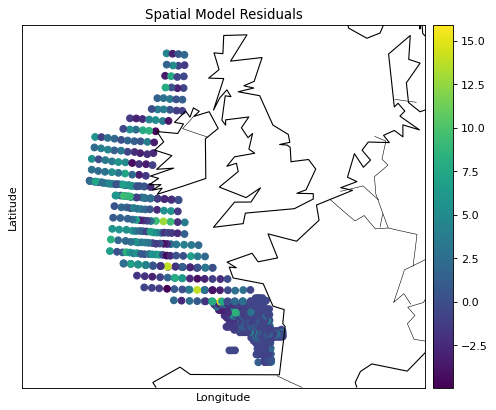

In [22]:
plt.figure(figsize=(8, 6), dpi=80)
m = Basemap(width=2000000,height=1800000,projection='lcc',
            resolution='c',
            lat_1=48.,
            lat_2=55,
            lat_0=51,
            lon_0=-5.)
m.drawcoastlines()
m.drawcountries()
x, y = m(resid_table.lon, resid_table.lat)  # transform coordinates
m.scatter(x,y, c = resid_table.spatial)
m.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Model Residuals')

plt.show()

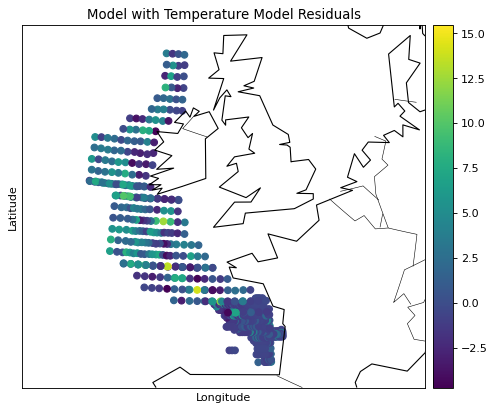

In [23]:
plt.figure(figsize=(8, 6), dpi=80)
m = Basemap(width=2000000,height=1800000,projection='lcc',
            resolution='c',
            lat_1=48.,
            lat_2=55,
            lat_0=51,
            lon_0=-5.)
m.drawcoastlines()
m.drawcountries()
x, y = m(resid_table.lon, resid_table.lat)  # transform coordinates
m.scatter(x,y, c = resid_table.depth)
m.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Model with Temperature Model Residuals')

plt.show()

For both models, in the Bay of Biscay we tend to overestimate the number of eggs which likely contributes to the less than satisfactory residual plots. In the other regions, there is not very much apparent spatial correlation with the residuals.

### Interpolating the Models

Since we do not have temperature observations across a grid of locations along the region of interest, the spatial model will be interpolated to make predictions along the norther Atlantic Ocean near the European coast to predict the number of mackerel eggs. To generate a grid, we will want to restrict the interpolation region to a reasonable area that does not extrapolate too much or interpolate over land areas to a significant extent. To begin the `gamair` package contains a prediction grid to make a map of egg counts across the region of interest. As with the original data this is gotten from R and saved as a `.csv` for use here. 

In [24]:
pred_grid = pd.read_csv('mackp.csv')
pred_grid.head()

Unnamed: 0   lon   lat  b.depth  area.index    c.dist   salinity  \
0           1 -3.00  44.0     1780          49  0.375641  35.833233   
1           4 -2.75  44.0     1431          50  0.377874  35.581787   
2           7 -2.50  44.0     1013          51  0.403829  35.338566   
3          10 -2.25  44.0      683          52  0.215450  35.177772   
4          13 -2.00  44.0      202          53  0.032590  34.996311   

   temp.surf   temp.20m  
0  16.572729  16.492307  
1  16.774421  16.709183  
2  17.036978  17.034212  
3  16.971560  16.967780  
4  16.942321  16.885797

We are also provided with measurments of the other variables as well. Let's make prediction using the provided data with both models. The square-root of the predicted values will be be taken to make the plotting a litte more clear:

In [25]:
## sub-set prediction grids
spatial_grid = pred_grid[['lat', 'lon']]
temp20_grid = pred_grid[['lat', 'lon', 'temp.20m']]

## make predictions
spatial_preds = np.sqrt(spatial_gam.predict(spatial_grid))
temp20_preds = np.sqrt(temp20_gam.predict(temp20_grid))

## create variables for mapping
preds = spatial_grid
preds.insert(2, 'spatial_preds', spatial_preds)
preds.insert(3, 'temp20_preds', temp20_preds)

preds.head()

lat   lon  spatial_preds  temp20_preds
0  44.0 -3.00       0.437706      0.350406
1  44.0 -2.75       0.501618      0.440690
2  44.0 -2.50       0.615375      0.627367
3  44.0 -2.25       0.773146      0.788758
4  44.0 -2.00       0.950042      0.988975

With the prediction grid, we can produce smoothed predictions/estimates across the region of interest using both models:

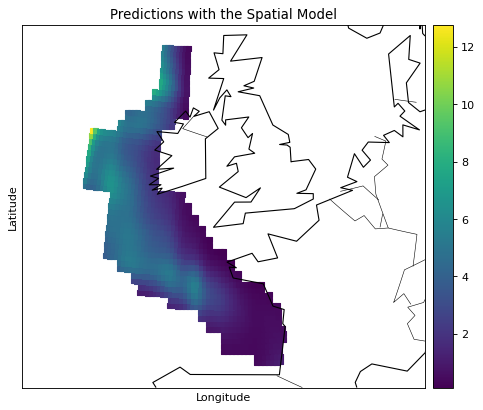

In [26]:
plt.figure(figsize=(8, 6), dpi=80)
m = Basemap(width=2000000,height=1800000,projection='lcc',
            resolution='c',
            lat_1=48.,
            lat_2=55,
            lat_0=51,
            lon_0=-5.)
m.drawcoastlines()
m.drawcountries()
x, y = m(preds.lon, preds.lat)  # transform coordinates
m.scatter(x,y, c = preds.spatial_preds,marker = 's', s = 20)
m.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predictions with the Spatial Model')

plt.show()

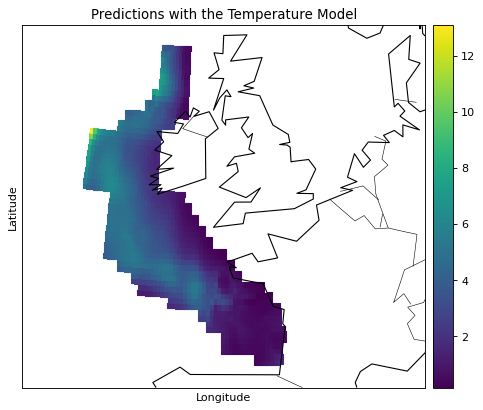

In [27]:
plt.figure(figsize=(8, 6), dpi=80)
m = Basemap(width=2000000,height=1800000,projection='lcc',
            resolution='c',
            lat_1=48.,
            lat_2=55,
            lat_0=51,
            lon_0=-5.)
m.drawcoastlines()
m.drawcountries()
x, y = m(preds.lon, preds.lat)  # transform coordinates
m.scatter(x,y, c = preds.temp20_preds,marker = 's', s = 20)
m.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predictions with the Temperature Model')

plt.show()

Let's also plot the temperature at 20 meters below the surface across the region of interest to examine any apparent effect of this variable on the predictions/smoothing:

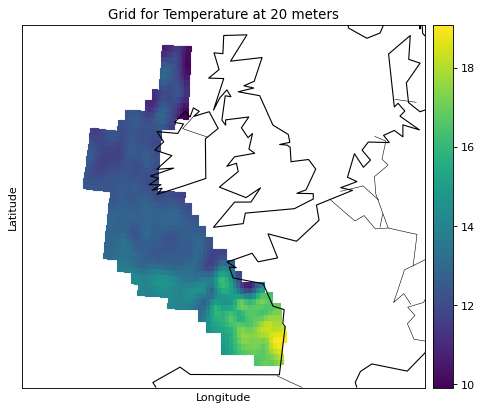

In [28]:
plt.figure(figsize=(8, 6), dpi=80)
m = Basemap(width=2000000,height=1800000,projection='lcc',
            resolution='c',
            lat_1=48.,
            lat_2=55,
            lat_0=51,
            lon_0=-5.)
m.drawcoastlines()
m.drawcountries()
x, y = m(pred_grid.lon, pred_grid.lat)  # transform coordinates
m.scatter(x,y, c = pred_grid[['temp.20m']].squeeze(),marker = 's', s = 20)
m.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Grid for Temperature at 20 meters')

plt.show()

We can see the Bay of Biscay has warmer waters than the other areas of interest. While the spatial model adequately smooths the data including the temperature variable suggests changes in temperature are associated with the number of eggs. Should water temperatures increase in a region in the north which previously had a high count of eggs, this may decrease with increasing temperature. 

### How might we produce a prediction grid in general?

Ultimately, we would want to produce a grid over the area based on the the boundaries set by the observations (such that we do no extrapolate too much). A few approaches could be taken:

* Join a bunch of grids together manually (eg. join 20 +/- 5 grids together into one data-frame). This seems rather tedious and not a very general procedure.

* Create a polygon surrounding the observation locations and place an equally spaced grid inside the polygon. Two polygon types can be examined:
    * Convex Hull (available in the scipy library) to create a convex polygon around the observations locations. This may not work in here since the polygon will pass over parts of France, England, and nearly all of Ireland. 
    * An Alpha-shape or Non-Convex Hull, which is more satisfactory for a case like this. 
    * In both cases above, a function would need to be written such that we could determine if a point lies inside or outside the polygon, then we could interpolate at that location. 

## Concluding Remarks

Here is a list of some observations from the brief analysis above:

* Generalized Additive Models (GAMs) provide a flexible but interpretable framework for non-linear modeling and spatial smoothing. We can include/exclude explanatory variable and apply statistical tests to guide our understanding of the model and the data. Moreover, we can smooth/interpolate data to produce a smoothed surface over an area of interest when examining spatial data.

* For the mackerel egg survey data a GAM with Poisson response was fitted to the data, with an exposure/offset term as the net area, where two models where two main models were considered:
    - A model with spatial variables
    - A model with spatial variables and water temperature variable. It was found that the temperature measured at 20 meters below the surface produced a model with a lower AIC.
    - There are some residual diagnostic issues, most notably the over-dispersion in the data. A different response family ought to be considered (e.g. quasi-poisson or negative binomial) but the `pygam` library does not include these currently.
    
* The modeling suggest low egg counts in the Bay of Biscay due to spatial effects and effects of temperature. 

* This analysis motivates interest in developing a method to generate a prediction grid inside a polygon for plotting the results of a model. 